# GRR Simulation

Testing GRR estimators with parameters matching the HAIPW simulations.


In [17]:
# Standard library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Import from our modules
from dgp import (
    generate_graph, 
    generate_covariates, 
    generate_potential_outcomes,
    assign_treatment, 
    compute_exposure, 
    observed_outcome
)
from propensity import monte_carlo_probabilities
from GRR import grr_estimator, compare_grr_methods

%matplotlib inline


In [18]:
# Standard library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Import from our modules
from dgp import (
    generate_graph, 
    generate_covariates, 
    generate_potential_outcomes,
    assign_treatment, 
    compute_exposure, 
    observed_outcome
)
from propensity import monte_carlo_probabilities
from GRR import grr_estimator, compare_grr_methods

%matplotlib inline


In [19]:
def run_grr_simulation(
    # --- data gen / design ---
    n=200, avg_degree=3.0, max_degree=9, k=3,
    treated_fraction=1/3,
    # exposures to compare
    d1=0, d2=2,
    # MC for pi's
    mc_reps=1000, seed_mc=111,
    # seeds
    seed_graph=123, seed_cov=1234, seed_out=999,
    # experiment reps
    B=200,
    # GRR methods to compare
    # Supported: 'linear', 'ridge', 'lasso', 'elasticnet', 'rf', 'gbm', 'mlp',
    #            'gat-linear', 'gat-lasso', 'gat-mlp'
    methods=['linear', 'ridge', 'lasso'],
    # options
    eps=1e-12,
    verbose=False,
    # GAT embedding options (used if any gat-* methods are included)
    gat_kwargs=None,
    **grr_kwargs
):
    """
    Full pipeline: generate (G,X,Y_pot), compute probabilities, then run
    GRR estimators for B randomizations.

    Supported methods:
      - Standard GRR: 'linear', 'ridge', 'lasso', 'elasticnet', 'rf', 'gbm', 'mlp'
      - GAT-enhanced GRR: 'gat-linear', 'gat-lasso', 'gat-mlp'
        * gat-linear: GAT leaf embeddings + linear GRR
        * gat-lasso: GAT leaf embeddings + lasso GRR
        * gat-mlp: GAT root embeddings + MLP GRR

    Returns:
      {
        'G','X','Y_pot','pi_id_all','Kn','true_tau',
        'results': {method -> np.ndarray of length B with tau_hat values},
        'losses': {method -> np.ndarray of length B with loss values},
        'summary': {method -> {'bias':..., 'sd':..., 'rmse':...}}
      }
    """
    from GRR import GAT_embedding
    
    # Default GAT kwargs
    if gat_kwargs is None:
        gat_kwargs = {}
    
    # Check if any GAT methods are requested
    gat_methods = {'gat-linear', 'gat-lasso', 'gat-mlp'}
    use_gat = bool(gat_methods.intersection(set(methods)))
    
    # -------------------------
    # Steps 1-3: graph & covariates & potential outcomes
    # -------------------------
    G, H = generate_graph(n=n, avg_degree=avg_degree, max_degree=max_degree, seed=seed_graph)
    X, X_noi = generate_covariates(H, seed=seed_cov)
    # X_run takes the column 1,2,4 of X
    X_run = X[:, [0, 3]]
    Y_pot = generate_potential_outcomes(H, X_noi, k=k, seed=seed_out)
    true_tau = float(np.mean(Y_pot[:, d1] - Y_pot[:, d2]))

    # -------------------------
    # Step 4: MC probs π_i(d)
    # -------------------------
    pi_id_all, _, _, _ = monte_carlo_probabilities(
        G, treated_fraction, k, mc_reps, seed_mc, d1, d2
    )

    # -------------------------
    # Step 5: Build Kn matrix
    # -------------------------
    # Kn: indicator matrix where (i,j) = 1 if nodes i and j have common neighbors
    Kn = (G @ G.T > 0).astype(int)
    
    # Adjacency matrix for GAT
    A_adj = G.astype(float)

    # -------------------------
    # Storage for results
    # -------------------------
    results = {m: np.zeros(B, dtype=float) for m in methods}
    losses = {m: np.zeros(B, dtype=float) for m in methods}

    # -------------------------
    # Repeat randomizations B times
    # -------------------------
    for b in tqdm(range(B), desc="Monte Carlo simulations", disable=not True):
        A_treat = assign_treatment(n, treated_fraction=treated_fraction, seed=None)
        D = compute_exposure(G, A_treat, k)
        Y = observed_outcome(Y_pot, D, k=k)
        
        # Get GAT embeddings if needed (once per randomization)
        gat_embeddings = None
        if use_gat:
            try:
                gat_embeddings = GAT_embedding(
                    X_run, A_adj, D, Y, k=k, d1=d1, d2=d2,
                    verbose=(b == 0 and verbose),  # Only print on first rep
                    **gat_kwargs
                )
            except Exception as e:
                if verbose:
                    print(f"Rep {b}, GAT embedding failed: {e}")
                # Mark all GAT methods as failed for this rep
                for m in methods:
                    if m in gat_methods:
                        results[m][b] = np.nan
                        losses[m][b] = np.nan

        # Run each GRR method
        for method in methods:
            try:
                if method == 'gat-linear':
                    if gat_embeddings is None:
                        raise ValueError("GAT embeddings not available")
                    # Use leaf embeddings with linear GRR
                    res = grr_estimator(
                        Y, D, X_run, d1, d2, pi_id_all, Kn,
                        method='linear', eps=eps,
                        X1=gat_embeddings['X_GAT_leaf'][0],
                        X2=gat_embeddings['X_GAT_leaf'][1],
                        **{kk: v for kk, v in grr_kwargs.items() if kk in ['alpha']}
                    )
                elif method == 'gat-lasso':
                    if gat_embeddings is None:
                        raise ValueError("GAT embeddings not available")
                    # Use leaf embeddings with lasso GRR
                    res = grr_estimator(
                        Y, D, X_run, d1, d2, pi_id_all, Kn,
                        method='lasso', eps=eps,
                        X1=gat_embeddings['X_GAT_leaf'][0],
                        X2=gat_embeddings['X_GAT_leaf'][1],
                        **{kk: v for kk, v in grr_kwargs.items() if kk in ['alpha']}
                    )
                elif method == 'gat-mlp':
                    if gat_embeddings is None:
                        raise ValueError("GAT embeddings not available")
                    # Use root embeddings with MLP GRR
                    res = grr_estimator(
                        Y, D, X_run, d1, d2, pi_id_all, Kn,
                        method='mlp', eps=eps,
                        X1=gat_embeddings['X_GAT_root'],
                        X2=gat_embeddings['X_GAT_root'],
                        **{kk: v for kk, v in grr_kwargs.items() 
                           if kk in ['hidden_dims', 'n_epochs', 'lr', 'weight_decay', 
                                    'dropout', 'early_stopping', 'patience']}
                    )
                else:
                    # Standard GRR method
                    res = grr_estimator(
                        Y, D, X_run, d1, d2, pi_id_all, Kn,
                        method=method, eps=eps, **grr_kwargs
                    )
                results[method][b] = res['tau_hat']
                losses[method][b] = res['loss']
            except Exception as e:
                if verbose:
                    print(f"Rep {b}, method {method}: {e}")
                results[method][b] = np.nan
                losses[method][b] = np.nan

    # -------------------------
    # Summaries (bias vs true_tau, and sd)
    # -------------------------
    summary = {}
    for m in methods:
        v = results[m]
        v_valid = v[~np.isnan(v)]
        if len(v_valid) > 0:
            bias = float(np.mean(v_valid) - true_tau)
            sd = float(np.std(v_valid, ddof=1))
            rmse = float(np.sqrt(bias**2 + sd**2))
            summary[m] = {"bias": bias, "sd": sd, "rmse": rmse, "n_valid": len(v_valid)}
        else:
            summary[m] = {"bias": np.nan, "sd": np.nan, "rmse": np.nan, "n_valid": 0}

    out = dict(
        G=G, H=H, X=X, Y_pot=Y_pot,
        pi_id_all=pi_id_all, Kn=Kn,
        true_tau=true_tau,
        results=results,
        losses=losses,
        summary=summary,
        methods=methods
    )
    return out


In [20]:
# Visualize results: Boxplot of errors (filtered to valid methods)
def plot_grr_results(out, figsize=(16, 5)):
    """Plot boxplot of errors and bar chart of bias/sd/rmse."""
    true_tau = out['true_tau']
    summary = out['summary']
    results = out['results']
    
    # Filter to valid methods only
    valid_methods = [m for m in out['methods'] if summary[m]['n_valid'] > 0]
    
    if len(valid_methods) == 0:
        print("No valid methods to plot!")
        return
    
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # Boxplot of errors
    errors = [results[m][~np.isnan(results[m])] - true_tau for m in valid_methods]
    bp = axes[0].boxplot(errors, labels=valid_methods, patch_artist=True, showfliers=False)
    colors = plt.cm.Set3(np.linspace(0, 1, len(valid_methods)))
    for box, color in zip(bp['boxes'], colors):
        box.set_facecolor(color)
        box.set_edgecolor('#444444')
    for median in bp['medians']:
        median.set_color('#222222')
        median.set_linewidth(1.5)
    axes[0].axhline(0.0, color='k', linestyle='--', linewidth=1, alpha=0.6)
    axes[0].set_ylabel(r'Error $\hat{\tau} - \tau^*$')
    axes[0].set_title('GRR Estimator Errors')
    axes[0].tick_params(axis='x', rotation=30)
    
    # Bar chart of bias/sd/rmse
    x = np.arange(len(valid_methods))
    width = 0.25
    
    biases = [summary[m]['bias'] for m in valid_methods]
    sds = [summary[m]['sd'] for m in valid_methods]
    rmses = [summary[m]['rmse'] for m in valid_methods]
    
    axes[1].bar(x - width, biases, width=width, label='Bias', alpha=0.8)
    axes[1].bar(x, sds, width=width, label='SD', alpha=0.8)
    axes[1].bar(x + width, rmses, width=width, label='RMSE', alpha=0.8)
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(valid_methods)
    axes[1].set_ylabel('Value')
    axes[1].set_title('Bias / SD / RMSE by Method')
    axes[1].legend()
    axes[1].tick_params(axis='x', rotation=30)
    
    plt.tight_layout()
    plt.show()

## Run GRR Simulation (mimicking out1 from simulation.ipynb)

Test the GRR estimators with parameters similar to the HAIPW simulation.


In [21]:
# Run GRR simulation with ALL methods including trees and MLP
# Parameters similar to out1 from simulation.ipynb

# ALL_METHODS = ['linear', 'ridge', 'lasso', 'elasticnet', 'rf', 'gbm', 'mlp']
ALL_METHODS = ['linear', 'lasso', 'gat-linear', 'gat-lasso']

# Best GAT config from tuning: shallower GAT, deeper outcome heads, no dropout, no IPM
# GAT_CONFIG = {
#     'gat_hidden_dims': [32],      # Shallower GAT encoder
#     'rep_dim': 16,                # Representation dimension
#     'head_hidden_dims': [64, 32, 16],  # Deeper outcome heads
#     'heads': 4,                   # Attention heads
#     'dropout': 0.0,               # No dropout (best from tuning)
#     'lambda_ipm': 0.0,            # No IPM regularization (best from tuning)
#     'n_epochs': 400,              # Training epochs
#     'lr': 0.001,                  # Learning rate
#     'weight_decay': 1e-4,         # L2 regularization
#     'early_stopping': True,
#     'patience': 50,
# }

GAT_CONFIG = {
    'gat_hidden_dims': [64, 64, 64, 64, 32],  # 5-layer deep GAT
    'rep_dim': 64,
    'head_hidden_dims': [64, 32],
    'heads': 4,
    'dropout': 0.0,
    'lambda_ipm': 0.0,
    'n_epochs': 600,
    'lr': 0.001,
    'weight_decay': 1e-4,
    'early_stopping': True,
    'patience': 100,
}

grr_out1 = run_grr_simulation(
    n=2000, avg_degree=3.0, max_degree=9, k=3,
    treated_fraction=1/3,
    d1=0, d2=2,
    mc_reps=500, seed_mc=111,
    seed_graph=123, seed_cov=1234, seed_out=999,
    B=20,  # Reduced for testing with slow methods; increase to 200+ for final results
    methods=ALL_METHODS,
    eps=1e-12,
    verbose=False,
    # GAT embedding config
    gat_kwargs=GAT_CONFIG,
    # Linear method params
    alpha=0.01,
    l1_ratio=0.5,
    # Tree params
    n_estimators=20,
    max_depth=5,
    min_samples_leaf=10,
    random_state=42,
    # MLP params (best config from tuning: dropout=0.1 gave RMSE=0.102)
    hidden_dims=[64, 32, 4],
    n_epochs=500,
    lr=0.0005,
    weight_decay=0.000,
    dropout=0.1,
    early_stopping=True,
    patience=50
)


Monte Carlo simulations:   0%|          | 0/20 [00:00<?, ?it/s]

[GATOutcomeModel] Using device: cuda
[GATOutcomeModel] GPU: NVIDIA A100-SXM4-80GB
[GATOutcomeModel] Exposure levels: 0 to 2 (3 levels)


/home/colligo/personal-research/optimal-GRR/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.161e+05, tolerance: 3.899e+02
  model = cd_fast.enet_coordinate_descent(
Monte Carlo simulations:   5%|▌         | 1/20 [00:25<08:02, 25.39s/it]

[GATOutcomeModel] Using device: cuda
[GATOutcomeModel] GPU: NVIDIA A100-SXM4-80GB
[GATOutcomeModel] Exposure levels: 0 to 2 (3 levels)


/home/colligo/personal-research/optimal-GRR/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.814e+05, tolerance: 3.899e+02
  model = cd_fast.enet_coordinate_descent(
Monte Carlo simulations:  10%|█         | 2/20 [00:46<06:50, 22.83s/it]

[GATOutcomeModel] Using device: cuda
[GATOutcomeModel] GPU: NVIDIA A100-SXM4-80GB
[GATOutcomeModel] Exposure levels: 0 to 2 (3 levels)


/home/colligo/personal-research/optimal-GRR/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.639e+04, tolerance: 2.962e+02
  model = cd_fast.enet_coordinate_descent(
Monte Carlo simulations:  15%|█▌        | 3/20 [01:14<07:09, 25.28s/it]

[GATOutcomeModel] Using device: cuda
[GATOutcomeModel] GPU: NVIDIA A100-SXM4-80GB
[GATOutcomeModel] Exposure levels: 0 to 2 (3 levels)


/home/colligo/personal-research/optimal-GRR/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.009e+04, tolerance: 3.717e+02
  model = cd_fast.enet_coordinate_descent(
Monte Carlo simulations:  20%|██        | 4/20 [01:59<08:46, 32.90s/it]

[GATOutcomeModel] Using device: cuda
[GATOutcomeModel] GPU: NVIDIA A100-SXM4-80GB
[GATOutcomeModel] Exposure levels: 0 to 2 (3 levels)


/home/colligo/personal-research/optimal-GRR/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.039e+05, tolerance: 3.839e+02
  model = cd_fast.enet_coordinate_descent(
Monte Carlo simulations:  25%|██▌       | 5/20 [02:25<07:36, 30.43s/it]

[GATOutcomeModel] Using device: cuda
[GATOutcomeModel] GPU: NVIDIA A100-SXM4-80GB
[GATOutcomeModel] Exposure levels: 0 to 2 (3 levels)


/home/colligo/personal-research/optimal-GRR/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.086e+04, tolerance: 2.479e+02
  model = cd_fast.enet_coordinate_descent(
Monte Carlo simulations:  30%|███       | 6/20 [02:52<06:51, 29.42s/it]

[GATOutcomeModel] Using device: cuda
[GATOutcomeModel] GPU: NVIDIA A100-SXM4-80GB
[GATOutcomeModel] Exposure levels: 0 to 2 (3 levels)


/home/colligo/personal-research/optimal-GRR/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.059e+04, tolerance: 2.312e+02
  model = cd_fast.enet_coordinate_descent(
Monte Carlo simulations:  35%|███▌      | 7/20 [03:17<06:01, 27.81s/it]

[GATOutcomeModel] Using device: cuda
[GATOutcomeModel] GPU: NVIDIA A100-SXM4-80GB
[GATOutcomeModel] Exposure levels: 0 to 2 (3 levels)


/home/colligo/personal-research/optimal-GRR/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.900e+04, tolerance: 2.621e+02
  model = cd_fast.enet_coordinate_descent(
Monte Carlo simulations:  40%|████      | 8/20 [03:53<06:05, 30.44s/it]

[GATOutcomeModel] Using device: cuda
[GATOutcomeModel] GPU: NVIDIA A100-SXM4-80GB
[GATOutcomeModel] Exposure levels: 0 to 2 (3 levels)


/home/colligo/personal-research/optimal-GRR/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.496e+04, tolerance: 3.175e+02
  model = cd_fast.enet_coordinate_descent(
Monte Carlo simulations:  45%|████▌     | 9/20 [04:18<05:15, 28.72s/it]

[GATOutcomeModel] Using device: cuda
[GATOutcomeModel] GPU: NVIDIA A100-SXM4-80GB
[GATOutcomeModel] Exposure levels: 0 to 2 (3 levels)


/home/colligo/personal-research/optimal-GRR/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.506e+04, tolerance: 2.923e+02
  model = cd_fast.enet_coordinate_descent(
Monte Carlo simulations:  50%|█████     | 10/20 [04:45<04:42, 28.28s/it]

[GATOutcomeModel] Using device: cuda
[GATOutcomeModel] GPU: NVIDIA A100-SXM4-80GB
[GATOutcomeModel] Exposure levels: 0 to 2 (3 levels)


/home/colligo/personal-research/optimal-GRR/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.274e+04, tolerance: 2.641e+02
  model = cd_fast.enet_coordinate_descent(
Monte Carlo simulations:  55%|█████▌    | 11/20 [05:18<04:26, 29.61s/it]

[GATOutcomeModel] Using device: cuda
[GATOutcomeModel] GPU: NVIDIA A100-SXM4-80GB
[GATOutcomeModel] Exposure levels: 0 to 2 (3 levels)


/home/colligo/personal-research/optimal-GRR/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.929e+04, tolerance: 3.412e+02
  model = cd_fast.enet_coordinate_descent(
Monte Carlo simulations:  60%|██████    | 12/20 [05:41<03:41, 27.74s/it]

[GATOutcomeModel] Using device: cuda
[GATOutcomeModel] GPU: NVIDIA A100-SXM4-80GB
[GATOutcomeModel] Exposure levels: 0 to 2 (3 levels)


/home/colligo/personal-research/optimal-GRR/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.186e+04, tolerance: 3.514e+02
  model = cd_fast.enet_coordinate_descent(
Monte Carlo simulations:  65%|██████▌   | 13/20 [06:08<03:13, 27.60s/it]

[GATOutcomeModel] Using device: cuda
[GATOutcomeModel] GPU: NVIDIA A100-SXM4-80GB
[GATOutcomeModel] Exposure levels: 0 to 2 (3 levels)


/home/colligo/personal-research/optimal-GRR/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.811e+04, tolerance: 1.841e+02
  model = cd_fast.enet_coordinate_descent(
Monte Carlo simulations:  70%|███████   | 14/20 [06:31<02:36, 26.13s/it]

[GATOutcomeModel] Using device: cuda
[GATOutcomeModel] GPU: NVIDIA A100-SXM4-80GB
[GATOutcomeModel] Exposure levels: 0 to 2 (3 levels)


/home/colligo/personal-research/optimal-GRR/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.494e+04, tolerance: 2.111e+02
  model = cd_fast.enet_coordinate_descent(
Monte Carlo simulations:  75%|███████▌  | 15/20 [06:58<02:12, 26.47s/it]

[GATOutcomeModel] Using device: cuda
[GATOutcomeModel] GPU: NVIDIA A100-SXM4-80GB
[GATOutcomeModel] Exposure levels: 0 to 2 (3 levels)


/home/colligo/personal-research/optimal-GRR/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.546e+04, tolerance: 2.759e+02
  model = cd_fast.enet_coordinate_descent(
Monte Carlo simulations:  80%|████████  | 16/20 [07:25<01:45, 26.43s/it]

[GATOutcomeModel] Using device: cuda
[GATOutcomeModel] GPU: NVIDIA A100-SXM4-80GB
[GATOutcomeModel] Exposure levels: 0 to 2 (3 levels)


/home/colligo/personal-research/optimal-GRR/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.873e+04, tolerance: 1.818e+02
  model = cd_fast.enet_coordinate_descent(
Monte Carlo simulations:  85%|████████▌ | 17/20 [07:51<01:19, 26.44s/it]

[GATOutcomeModel] Using device: cuda
[GATOutcomeModel] GPU: NVIDIA A100-SXM4-80GB
[GATOutcomeModel] Exposure levels: 0 to 2 (3 levels)


/home/colligo/personal-research/optimal-GRR/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.317e+05, tolerance: 3.639e+02
  model = cd_fast.enet_coordinate_descent(
Monte Carlo simulations:  90%|█████████ | 18/20 [08:14<00:50, 25.34s/it]

[GATOutcomeModel] Using device: cuda
[GATOutcomeModel] GPU: NVIDIA A100-SXM4-80GB
[GATOutcomeModel] Exposure levels: 0 to 2 (3 levels)


/home/colligo/personal-research/optimal-GRR/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.969e+04, tolerance: 3.095e+02
  model = cd_fast.enet_coordinate_descent(
Monte Carlo simulations:  95%|█████████▌| 19/20 [08:46<00:27, 27.31s/it]

[GATOutcomeModel] Using device: cuda
[GATOutcomeModel] GPU: NVIDIA A100-SXM4-80GB
[GATOutcomeModel] Exposure levels: 0 to 2 (3 levels)


/home/colligo/personal-research/optimal-GRR/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.654e+04, tolerance: 4.158e+02
  model = cd_fast.enet_coordinate_descent(
Monte Carlo simulations: 100%|██████████| 20/20 [09:11<00:00, 27.59s/it]


In [22]:
# Display results summary
print(f"True tau: {grr_out1['true_tau']:.6f}")
print(f"\n{'Method':<15} {'Bias':>12} {'SD':>12} {'RMSE':>12} {'Valid':>8} {'Mean Loss':>15}")
print("-" * 75)
for method in grr_out1['methods']:
    stats = grr_out1['summary'][method]
    mean_loss = np.nanmean(grr_out1['losses'][method])
    if stats['n_valid'] > 0:
        print(f"{method:<15} {stats['bias']:>12.6f} {stats['sd']:>12.6f} {stats['rmse']:>12.6f} {stats['n_valid']:>8} {mean_loss:>15.2f}")
    else:
        print(f"{method:<15} {'FAILED':>12} {'FAILED':>12} {'FAILED':>12} {0:>8} {'N/A':>15}")

# Sort by RMSE
print("\n--- Sorted by RMSE (best to worst) ---")
valid_methods = [(m, grr_out1['summary'][m]) for m in grr_out1['methods'] if grr_out1['summary'][m]['n_valid'] > 0]
valid_methods.sort(key=lambda x: x[1]['rmse'])
for m, stats in valid_methods:
    print(f"{m:<15} RMSE={stats['rmse']:.6f}")


True tau: -0.593927

Method                  Bias           SD         RMSE    Valid       Mean Loss
---------------------------------------------------------------------------
linear             -0.041892     0.110004     0.117711       20       100710.29
lasso              -0.033706     0.103482     0.108833       20       108846.12
gat-linear          0.016453     0.122268     0.123370       20        75539.12
gat-lasso           0.071821     0.136190     0.153968       20        63246.68

--- Sorted by RMSE (best to worst) ---
lasso           RMSE=0.108833
linear          RMSE=0.117711
gat-linear      RMSE=0.123370
gat-lasso       RMSE=0.153968


/tmp/ipykernel_207974/2472776638.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[0].boxplot(errors, labels=valid_methods, patch_artist=True, showfliers=False)


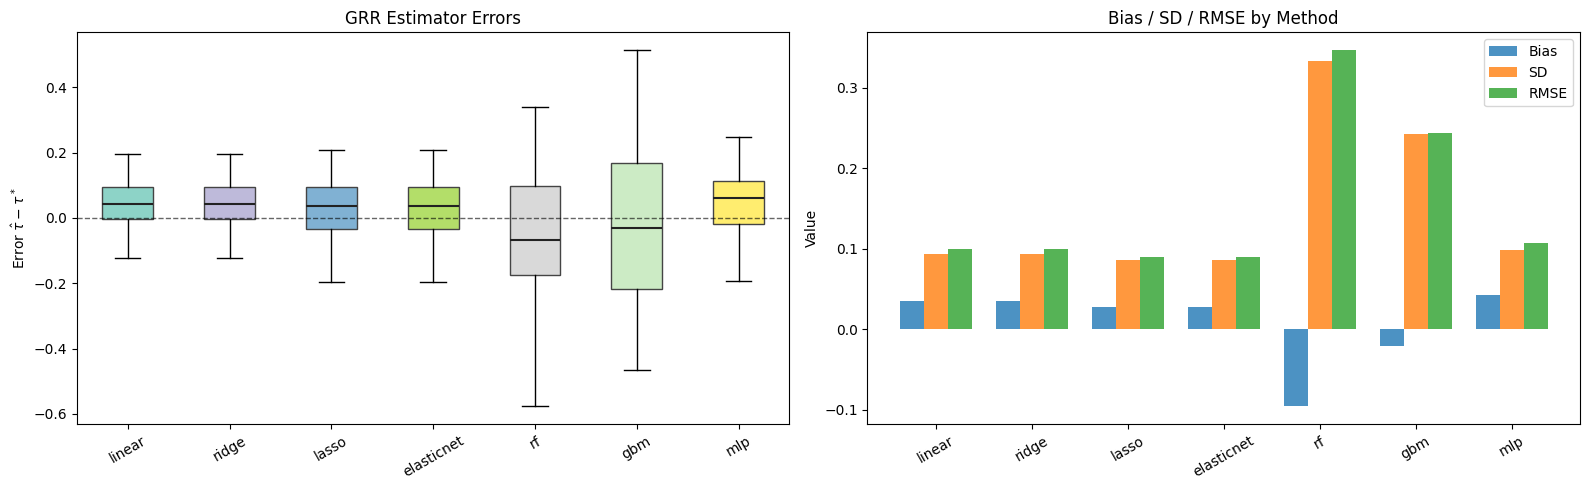

In [ ]:
plot_grr_results(grr_out1)

In [ ]:
# Compare mean weighted loss across methods (lower is better)
print("Mean Weighted Loss (res' @ Kn @ res) by Method:")
print("-" * 50)

# Sort by loss
loss_data = []
for method in grr_out1['methods']:
    mean_loss = np.nanmean(grr_out1['losses'][method])
    n_valid = grr_out1['summary'][method]['n_valid']
    if n_valid > 0:
        loss_data.append((method, mean_loss, n_valid))

loss_data.sort(key=lambda x: x[1])
for method, loss, n_valid in loss_data:
    print(f"{method:<15}: {loss:>15.2f}  (n={n_valid})")


## output 4

In [ ]:
# Run GRR simulation with ALL methods including trees and MLP
# Parameters similar to out1 from simulation.ipynb

# ALL_METHODS = ['linear', 'ridge', 'lasso', 'elasticnet', 'rf', 'gbm', 'mlp']
ALL_METHODS = ['linear', 'lasso', 'gat-linear', 'gat-lasso']

# # Best GAT config from tuning: shallower GAT, deeper outcome heads, no dropout, no IPM
# GAT_CONFIG = {
#     'gat_hidden_dims': [32],      # Shallower GAT encoder
#     'rep_dim': 16,                # Representation dimension
#     'head_hidden_dims': [64, 32, 16],  # Deeper outcome heads
#     'heads': 4,                   # Attention heads
#     'dropout': 0.0,               # No dropout (best from tuning)
#     'lambda_ipm': 0.0,            # No IPM regularization (best from tuning)
#     'n_epochs': 400,              # Training epochs
#     'lr': 0.001,                  # Learning rate
#     'weight_decay': 1e-4,         # L2 regularization
#     'early_stopping': True,
#     'patience': 50,
# }

GAT_CONFIG = {
    'gat_hidden_dims': [64, 64, 64, 64, 32],  # 5-layer deep GAT
    'rep_dim': 64,
    'head_hidden_dims': [64, 16],
    'heads': 4,
    'dropout': 0.0,
    'lambda_ipm': 0.0,
    'n_epochs': 600,
    'lr': 0.001,
    'weight_decay': 1e-4,
    'early_stopping': True,
    'patience': 100,
}

grr_out4 = run_grr_simulation(
    n=2000, avg_degree=10, max_degree=19, k=2,
    treated_fraction=1/2,
    d1=0, d2=1,  # Comparing untreated vs directly treated
    mc_reps=5000, seed_mc=42,
    seed_graph=42, seed_cov=42, seed_out=42,
    B=20,  # Reduced for testing; increase to 200+ for final results
    methods=ALL_METHODS,
    eps=1e-12,
    verbose=False,
    # GAT embedding config
    gat_kwargs=GAT_CONFIG,
    # Linear method params
    alpha=0.01,
    l1_ratio=0.5,
    # Tree params
    n_estimators=20,
    max_depth=5,
    min_samples_leaf=10,
    random_state=42,
    # MLP params (best config from tuning: dropout=0.1 gave RMSE=0.102)
    hidden_dims=[64, 32, 4],
    n_epochs=500,
    lr=0.0005,
    weight_decay=0.000,
    dropout=0.1,
    early_stopping=True,
    patience=50
)

Monte Carlo simulations:   0%|          | 0/20 [00:00<?, ?it/s]

[GATOutcomeModel] Using device: cuda
[GATOutcomeModel] GPU: NVIDIA A100-SXM4-80GB
[GATOutcomeModel] Exposure levels: 0 to 1 (2 levels)


Monte Carlo simulations:   5%|▌         | 1/20 [00:14<04:41, 14.79s/it]

[GATOutcomeModel] Using device: cuda
[GATOutcomeModel] GPU: NVIDIA A100-SXM4-80GB
[GATOutcomeModel] Exposure levels: 0 to 1 (2 levels)


/home/colligo/personal-research/optimal-GRR/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.683e+05, tolerance: 1.223e+03
  model = cd_fast.enet_coordinate_descent(
Monte Carlo simulations:  10%|█         | 2/20 [00:40<06:23, 21.32s/it]

[GATOutcomeModel] Using device: cuda
[GATOutcomeModel] GPU: NVIDIA A100-SXM4-80GB
[GATOutcomeModel] Exposure levels: 0 to 1 (2 levels)


/home/colligo/personal-research/optimal-GRR/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.807e+05, tolerance: 1.211e+03
  model = cd_fast.enet_coordinate_descent(
Monte Carlo simulations:  15%|█▌        | 3/20 [01:01<06:02, 21.30s/it]

[GATOutcomeModel] Using device: cuda
[GATOutcomeModel] GPU: NVIDIA A100-SXM4-80GB
[GATOutcomeModel] Exposure levels: 0 to 1 (2 levels)


/home/colligo/personal-research/optimal-GRR/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.059e+05, tolerance: 1.214e+03
  model = cd_fast.enet_coordinate_descent(
Monte Carlo simulations:  20%|██        | 4/20 [01:32<06:36, 24.77s/it]

[GATOutcomeModel] Using device: cuda
[GATOutcomeModel] GPU: NVIDIA A100-SXM4-80GB
[GATOutcomeModel] Exposure levels: 0 to 1 (2 levels)


Monte Carlo simulations:  25%|██▌       | 5/20 [01:46<05:15, 21.01s/it]

[GATOutcomeModel] Using device: cuda
[GATOutcomeModel] GPU: NVIDIA A100-SXM4-80GB
[GATOutcomeModel] Exposure levels: 0 to 1 (2 levels)


Monte Carlo simulations:  30%|███       | 6/20 [02:00<04:21, 18.66s/it]

[GATOutcomeModel] Using device: cuda
[GATOutcomeModel] GPU: NVIDIA A100-SXM4-80GB
[GATOutcomeModel] Exposure levels: 0 to 1 (2 levels)


Monte Carlo simulations:  35%|███▌      | 7/20 [02:14<03:44, 17.27s/it]

[GATOutcomeModel] Using device: cuda
[GATOutcomeModel] GPU: NVIDIA A100-SXM4-80GB
[GATOutcomeModel] Exposure levels: 0 to 1 (2 levels)


Monte Carlo simulations:  40%|████      | 8/20 [02:28<03:13, 16.17s/it]

[GATOutcomeModel] Using device: cuda
[GATOutcomeModel] GPU: NVIDIA A100-SXM4-80GB
[GATOutcomeModel] Exposure levels: 0 to 1 (2 levels)


Monte Carlo simulations:  45%|████▌     | 9/20 [02:42<02:51, 15.57s/it]

[GATOutcomeModel] Using device: cuda
[GATOutcomeModel] GPU: NVIDIA A100-SXM4-80GB
[GATOutcomeModel] Exposure levels: 0 to 1 (2 levels)


Monte Carlo simulations:  50%|█████     | 10/20 [02:58<02:35, 15.56s/it]

[GATOutcomeModel] Using device: cuda
[GATOutcomeModel] GPU: NVIDIA A100-SXM4-80GB
[GATOutcomeModel] Exposure levels: 0 to 1 (2 levels)


/home/colligo/personal-research/optimal-GRR/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.669e+05, tolerance: 1.168e+03
  model = cd_fast.enet_coordinate_descent(
Monte Carlo simulations:  55%|█████▌    | 11/20 [03:12<02:16, 15.14s/it]

[GATOutcomeModel] Using device: cuda
[GATOutcomeModel] GPU: NVIDIA A100-SXM4-80GB
[GATOutcomeModel] Exposure levels: 0 to 1 (2 levels)


/home/colligo/personal-research/optimal-GRR/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.346e+05, tolerance: 1.271e+03
  model = cd_fast.enet_coordinate_descent(
Monte Carlo simulations:  60%|██████    | 12/20 [03:35<02:19, 17.46s/it]

[GATOutcomeModel] Using device: cuda
[GATOutcomeModel] GPU: NVIDIA A100-SXM4-80GB
[GATOutcomeModel] Exposure levels: 0 to 1 (2 levels)


/home/colligo/personal-research/optimal-GRR/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.201e+05, tolerance: 1.175e+03
  model = cd_fast.enet_coordinate_descent(
Monte Carlo simulations:  65%|██████▌   | 13/20 [03:59<02:16, 19.54s/it]

[GATOutcomeModel] Using device: cuda
[GATOutcomeModel] GPU: NVIDIA A100-SXM4-80GB
[GATOutcomeModel] Exposure levels: 0 to 1 (2 levels)


Monte Carlo simulations:  70%|███████   | 14/20 [04:14<01:47, 17.96s/it]

[GATOutcomeModel] Using device: cuda
[GATOutcomeModel] GPU: NVIDIA A100-SXM4-80GB
[GATOutcomeModel] Exposure levels: 0 to 1 (2 levels)


/home/colligo/personal-research/optimal-GRR/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.689e+05, tolerance: 1.139e+03
  model = cd_fast.enet_coordinate_descent(
Monte Carlo simulations:  75%|███████▌  | 15/20 [04:33<01:31, 18.30s/it]

[GATOutcomeModel] Using device: cuda
[GATOutcomeModel] GPU: NVIDIA A100-SXM4-80GB
[GATOutcomeModel] Exposure levels: 0 to 1 (2 levels)


/home/colligo/personal-research/optimal-GRR/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.463e+05, tolerance: 1.168e+03
  model = cd_fast.enet_coordinate_descent(
Monte Carlo simulations:  80%|████████  | 16/20 [04:58<01:21, 20.34s/it]

[GATOutcomeModel] Using device: cuda
[GATOutcomeModel] GPU: NVIDIA A100-SXM4-80GB
[GATOutcomeModel] Exposure levels: 0 to 1 (2 levels)


/home/colligo/personal-research/optimal-GRR/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.052e+05, tolerance: 1.219e+03
  model = cd_fast.enet_coordinate_descent(
Monte Carlo simulations:  85%|████████▌ | 17/20 [05:20<01:02, 20.84s/it]

[GATOutcomeModel] Using device: cuda
[GATOutcomeModel] GPU: NVIDIA A100-SXM4-80GB
[GATOutcomeModel] Exposure levels: 0 to 1 (2 levels)


Monte Carlo simulations:  90%|█████████ | 18/20 [05:33<00:37, 18.71s/it]

[GATOutcomeModel] Using device: cuda
[GATOutcomeModel] GPU: NVIDIA A100-SXM4-80GB
[GATOutcomeModel] Exposure levels: 0 to 1 (2 levels)


Monte Carlo simulations:  95%|█████████▌| 19/20 [05:48<00:17, 17.32s/it]

[GATOutcomeModel] Using device: cuda
[GATOutcomeModel] GPU: NVIDIA A100-SXM4-80GB
[GATOutcomeModel] Exposure levels: 0 to 1 (2 levels)


/home/colligo/personal-research/optimal-GRR/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.762e+05, tolerance: 1.177e+03
  model = cd_fast.enet_coordinate_descent(
Monte Carlo simulations: 100%|██████████| 20/20 [06:18<00:00, 18.90s/it]


In [24]:
# Display out4 results summary
print(f"True tau: {grr_out4['true_tau']:.6f}")
print(f"\n{'Method':<15} {'Bias':>12} {'SD':>12} {'RMSE':>12} {'Valid':>8} {'Mean Loss':>15}")
print("-" * 75)
for method in grr_out4['methods']:
    stats = grr_out4['summary'][method]
    mean_loss = np.nanmean(grr_out4['losses'][method])
    if stats['n_valid'] > 0:
        print(f"{method:<15} {stats['bias']:>12.6f} {stats['sd']:>12.6f} {stats['rmse']:>12.6f} {stats['n_valid']:>8} {mean_loss:>15.2f}")
    else:
        print(f"{method:<15} {'FAILED':>12} {'FAILED':>12} {'FAILED':>12} {0:>8} {'N/A':>15}")

# Sort by RMSE
print("\n--- Sorted by RMSE (best to worst) ---")
valid_methods = [(m, grr_out4['summary'][m]) for m in grr_out4['methods'] if grr_out4['summary'][m]['n_valid'] > 0]
valid_methods.sort(key=lambda x: x[1]['rmse'])
for m, stats in valid_methods:
    print(f"{m:<15} RMSE={stats['rmse']:.6f}")


True tau: -0.371256

Method                  Bias           SD         RMSE    Valid       Mean Loss
---------------------------------------------------------------------------
linear              0.011668     0.197959     0.198303       20       126921.12
lasso              -0.003756     0.191690     0.191727       20       131470.77
gat-linear         -0.014413     0.208966     0.209462       20       154175.06
gat-lasso          -0.015313     0.207939     0.208502       20       151116.30

--- Sorted by RMSE (best to worst) ---
lasso           RMSE=0.191727
linear          RMSE=0.198303
gat-lasso       RMSE=0.208502
gat-linear      RMSE=0.209462


/tmp/ipykernel_1459086/3549698893.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[0].boxplot(errors, labels=valid_methods, patch_artist=True, showfliers=False)


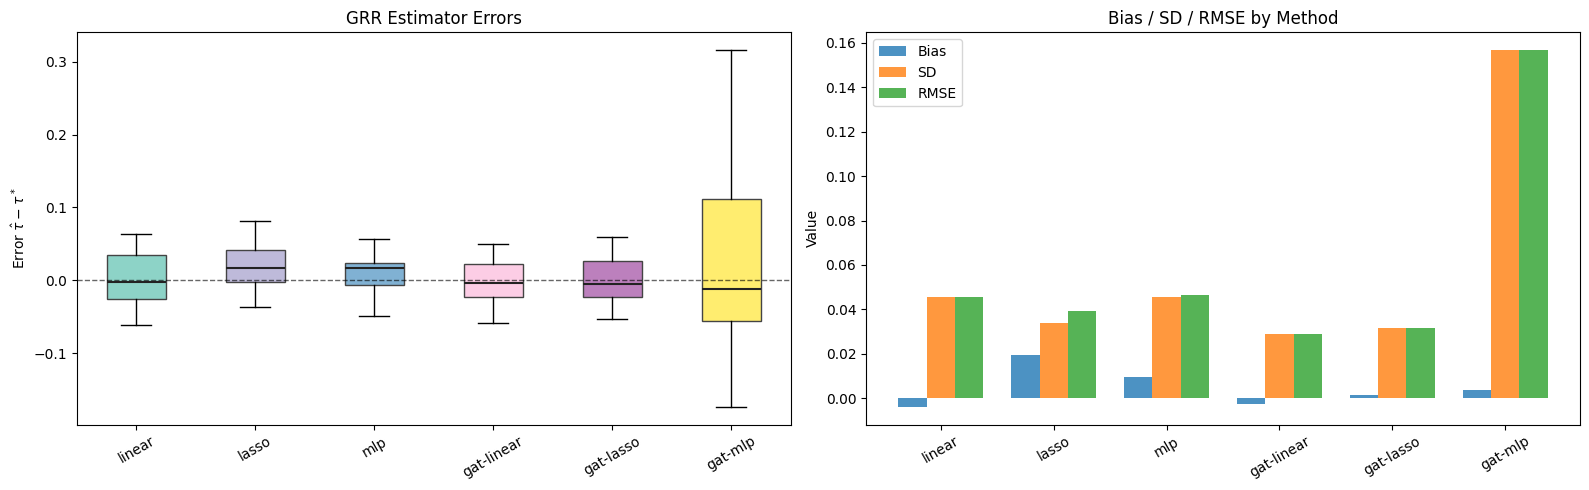

In [11]:
# Visualize out4 results
plot_grr_results(grr_out1)


In [10]:
# Compare mean weighted loss across methods for out4 (lower is better)
print("Mean Weighted Loss (res' @ Kn @ res) by Method for out4:")
print("-" * 50)

# Sort by loss
loss_data = []
for method in grr_out4['methods']:
    mean_loss = np.nanmean(grr_out4['losses'][method])
    n_valid = grr_out4['summary'][method]['n_valid']
    if n_valid > 0:
        loss_data.append((method, mean_loss, n_valid))

loss_data.sort(key=lambda x: x[1])
for method, loss, n_valid in loss_data:
    print(f"{method:<15}: {loss:>15.2f}  (n={n_valid})")


Mean Weighted Loss (res' @ Kn @ res) by Method for out4:
--------------------------------------------------


NameError: name 'grr_out4' is not defined

## Comparison: out1 vs out4

Compare the GRR estimator performance across the two different network configurations:
- **out1**: Low degree (avg_degree=3), k=3, treated_fraction=1/3, comparing d=0 vs d=2
- **out4**: High degree (avg_degree=10), k=2, treated_fraction=1/2, comparing d=0 vs d=1


In [ ]:
# Side-by-side comparison plot
def plot_comparison(out1, out4, name1="out1", name4="out4"):
    """Plot RMSE comparison across simulations."""
    methods = out1['methods']
    valid_methods = [m for m in methods 
                     if out1['summary'][m]['n_valid'] > 0 
                     and out4['summary'][m]['n_valid'] > 0]
    
    rmse1 = [out1['summary'][m]['rmse'] for m in valid_methods]
    rmse4 = [out4['summary'][m]['rmse'] for m in valid_methods]
    
    x = np.arange(len(valid_methods))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(x - width/2, rmse1, width, label=name1, alpha=0.8)
    ax.bar(x + width/2, rmse4, width, label=name4, alpha=0.8)
    
    ax.set_xlabel('Method')
    ax.set_ylabel('RMSE')
    ax.set_title('RMSE Comparison: out1 vs out4')
    ax.set_xticks(x)
    ax.set_xticklabels(valid_methods, rotation=30, ha='right')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_comparison(grr_out1, grr_out4)


In [ ]:
# Compare results across simulations
def compare_simulations(out1, out4, name1="out1", name4="out4"):
    """Compare RMSE and bias across two simulation outputs."""
    methods = out1['methods']
    
    print(f"{'Method':<15} | {name1:^30} | {name4:^30}")
    print(f"{'':^15} | {'Bias':>10} {'SD':>10} {'RMSE':>10} | {'Bias':>10} {'SD':>10} {'RMSE':>10}")
    print("-" * 85)
    
    for method in methods:
        s1 = out1['summary'][method]
        s4 = out4['summary'][method]
        
        if s1['n_valid'] > 0 and s4['n_valid'] > 0:
            print(f"{method:<15} | {s1['bias']:>10.4f} {s1['sd']:>10.4f} {s1['rmse']:>10.4f} | {s4['bias']:>10.4f} {s4['sd']:>10.4f} {s4['rmse']:>10.4f}")
        elif s1['n_valid'] > 0:
            print(f"{method:<15} | {s1['bias']:>10.4f} {s1['sd']:>10.4f} {s1['rmse']:>10.4f} | {'FAILED':>30}")
        elif s4['n_valid'] > 0:
            print(f"{method:<15} | {'FAILED':>30} | {s4['bias']:>10.4f} {s4['sd']:>10.4f} {s4['rmse']:>10.4f}")
        else:
            print(f"{method:<15} | {'FAILED':>30} | {'FAILED':>30}")

compare_simulations(grr_out1, grr_out4)


In [ ]:
# Show the best method for each simulation
print("Best performing methods by RMSE:")
print("-" * 40)

# Best for out1
best_out1 = min([(m, grr_out1['summary'][m]['rmse']) 
                  for m in grr_out1['methods'] 
                  if grr_out1['summary'][m]['n_valid'] > 0], 
                 key=lambda x: x[1])
print(f"out1 (low degree):  {best_out1[0]:<12} RMSE={best_out1[1]:.6f}")

# Best for out4
best_out4 = min([(m, grr_out4['summary'][m]['rmse']) 
                  for m in grr_out4['methods'] 
                  if grr_out4['summary'][m]['n_valid'] > 0], 
                 key=lambda x: x[1])
print(f"out4 (high degree): {best_out4[0]:<12} RMSE={best_out4[1]:.6f}")


## Summary

The GRR (General Regression) estimators minimize the weighted loss:
$$\min_{\theta_1, \theta_2} \text{res}' K_n \text{res}$$

All 7 methods (linear, ridge, lasso, elasticnet, rf, gbm, mlp) have been tested on both network configurations.


In [ ]:
# End of notebook


In [ ]:
# Hyperparameter tuning for MLP on out1 configuration
# Generate data once and test different MLP configs

from itertools import product

# Data generation parameters (same as out1)
n, avg_degree, max_degree, k = 2000, 3.0, 9, 3
d1, d2 = 0, 2
treated_fraction = 1/3
mc_reps, seed_mc = 500, 111
seed_graph, seed_cov, seed_out = 123, 1234, 999
B_tune = 10  # Fewer reps for tuning speed
eps = 1e-12

# Generate data once
print("Generating data for tuning...")
G, H = generate_graph(n=n, avg_degree=avg_degree, max_degree=max_degree, seed=seed_graph)
X, X_noi = generate_covariates(H, seed=seed_cov)
Y_pot = generate_potential_outcomes(H, X_noi, k=k, seed=seed_out)
true_tau = float(np.mean(Y_pot[:, d1] - Y_pot[:, d2]))
pi_id_all, _, _, _ = monte_carlo_probabilities(G, treated_fraction, k, mc_reps, seed_mc, d1, d2)
Kn = (G @ G.T > 0).astype(int)

print(f"True tau: {true_tau:.6f}")

# Hyperparameter grid for MLP
param_grid = {
    'hidden_dims': [[64, 32, 4], [128, 64, 8], [64, 32, 6], [32, 16, 4]],
    'lr': [0.01, 0.001, 0.0005],
    'dropout': [0.0, 0.1, 0.2],
    'weight_decay': [0.0, 0.001],
}

# Function to evaluate a single config
def evaluate_mlp_config(hidden_dims, lr, dropout, weight_decay, n_reps=B_tune):
    """Run MLP with given config and return mean RMSE and loss."""
    results = []
    losses = []
    
    np.random.seed(42)  # For reproducibility across configs
    for _ in range(n_reps):
        A = assign_treatment(n, treated_fraction=treated_fraction, seed=None)
        D = compute_exposure(G, A, k)
        Y = observed_outcome(Y_pot, D, k=k)
        
        try:
            res = grr_estimator(
                Y, D, X, d1, d2, pi_id_all, Kn,
                method='mlp',
                eps=eps,
                hidden_dims=hidden_dims,
                n_epochs=500,
                lr=lr,
                weight_decay=weight_decay,
                dropout=dropout,
                early_stopping=True,
                patience=50,
                verbose=False
            )
            results.append(res['tau_hat'])
            losses.append(res['loss'])
        except Exception as e:
            results.append(np.nan)
            losses.append(np.nan)
    
    results = np.array(results)
    valid = ~np.isnan(results)
    if valid.sum() > 0:
        bias = np.mean(results[valid]) - true_tau
        sd = np.std(results[valid], ddof=1) if valid.sum() > 1 else 0
        rmse = np.sqrt(bias**2 + sd**2)
        mean_loss = np.nanmean(losses)
        return {'bias': bias, 'sd': sd, 'rmse': rmse, 'loss': mean_loss, 'n_valid': valid.sum()}
    return {'bias': np.nan, 'sd': np.nan, 'rmse': np.nan, 'loss': np.nan, 'n_valid': 0}

# Run grid search
n_configs = len(param_grid['hidden_dims']) * len(param_grid['lr']) * len(param_grid['dropout']) * len(param_grid['weight_decay'])
print(f"\nRunning grid search over {n_configs} configurations...")
print("=" * 80)

tuning_results = []
for hidden_dims in param_grid['hidden_dims']:
    for lr in param_grid['lr']:
        for dropout in param_grid['dropout']:
            for weight_decay in param_grid['weight_decay']:
                config = {
                    'hidden_dims': hidden_dims,
                    'lr': lr,
                    'dropout': dropout,
                    'weight_decay': weight_decay
                }
                print(f"Testing: dims={hidden_dims}, lr={lr}, drop={dropout}, wd={weight_decay}...", end=" ")
                result = evaluate_mlp_config(**config)
                config.update(result)
                tuning_results.append(config)
                print(f"RMSE={result['rmse']:.4f}, Loss={result['loss']:.2f}")

# Convert to DataFrame for easier analysis
tuning_df = pd.DataFrame(tuning_results)
tuning_df = tuning_df.sort_values('rmse')

print("\n" + "=" * 80)
print("TOP 10 CONFIGURATIONS BY RMSE:")
print("=" * 80)
print(tuning_df.head(10).to_string(index=False))

# Best config
best_config = tuning_df.iloc[0]
print(f"\nBEST CONFIG:")
print(f"  hidden_dims: {best_config['hidden_dims']}")
print(f"  lr: {best_config['lr']}")
print(f"  dropout: {best_config['dropout']}")
print(f"  weight_decay: {best_config['weight_decay']}")
print(f"  RMSE: {best_config['rmse']:.6f}")
print(f"  Bias: {best_config['bias']:.6f}")
print(f"  SD: {best_config['sd']:.6f}")


Generating data for tuning...
True tau: -0.593927

Running grid search over 72 configurations...
Testing: dims=[64, 32, 4], lr=0.01, drop=0.0, wd=0.0... RMSE=118.3718, Loss=-48944496379.78
Testing: dims=[64, 32, 4], lr=0.01, drop=0.0, wd=0.001... RMSE=71.4477, Loss=-25380085647.76
Testing: dims=[64, 32, 4], lr=0.01, drop=0.1, wd=0.0... RMSE=0.1470, Loss=42603.80
Testing: dims=[64, 32, 4], lr=0.01, drop=0.1, wd=0.001... RMSE=0.0706, Loss=44431.48
Testing: dims=[64, 32, 4], lr=0.01, drop=0.2, wd=0.0... RMSE=0.0914, Loss=49440.27
Testing: dims=[64, 32, 4], lr=0.01, drop=0.2, wd=0.001... RMSE=0.1258, Loss=53043.88
Testing: dims=[64, 32, 4], lr=0.001, drop=0.0, wd=0.0... RMSE=0.1201, Loss=45710.18
Testing: dims=[64, 32, 4], lr=0.001, drop=0.0, wd=0.001... RMSE=0.1555, Loss=26960.28
Testing: dims=[64, 32, 4], lr=0.001, drop=0.1, wd=0.0... RMSE=0.2173, Loss=69377.26
Testing: dims=[64, 32, 4], lr=0.001, drop=0.1, wd=0.001... RMSE=0.0861, Loss=118877.26
Testing: dims=[64, 32, 4], lr=0.001, drop